<a href="https://colab.research.google.com/github/Shayshoon/ML_2/blob/main/HW2_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW1 - Data Exploration and Preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the dataset

In [3]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


In [4]:
dataset = pd.read_csv(filename)

In [5]:
dataset.shape

(1250, 25)

# How to download from Colab?

In [6]:
# from google.colab import files
# outputPath = "saved_file.csv"
# dataset.to_csv(outputPath)
# files.download(outputPath)

In [7]:
from sklearn.model_selection import train_test_split

# partition data like in hw1
raw_train_df, raw_test_df = train_test_split(dataset, test_size=0.2, random_state=15)

In [8]:
# @title Default title text
def prepare_data(training_data, new_data):
	import numpy as np
	import pandas as pd
	from sklearn.preprocessing import MinMaxScaler, StandardScaler

	# fill null values
	fillna_values = {"household_income": training_data.household_income.median(),
	 				 "PCR_02": training_data.PCR_02.median()}
	prepared_data = new_data.fillna(value=fillna_values)

	# scale using minmax

	minmax_scaler = MinMaxScaler(feature_range=(-1,1))
	minmax_features = ['PCR_01','PCR_03','PCR_04','PCR_06','PCR_07','PCR_08', 'PCR_09']

	minmax_scaler.fit(training_data[minmax_features])
	prepared_data[minmax_features] = minmax_scaler.transform(prepared_data[minmax_features])

	# scale using standard

	standard_scaler = StandardScaler()
	standard_features = ['PCR_02','PCR_05','PCR_10']

	standard_scaler.fit(training_data[standard_features])
	prepared_data[standard_features] = standard_scaler.transform(prepared_data[standard_features])

	# generate new feature `blood_type_group`

	prepared_data['blood_type_group'] = prepared_data['blood_type'].isin(["O+", "B+"])
# drop useless features (this step was changed from hw1, because we dropped the `blood_type` feature too.)
	prepared_data = prepared_data.drop(columns=['pcr_date', 'current_location'])

	return prepared_data


In [9]:
# Make sure target variables follow {1,-1} convention
dataset[['spread', 'risk']].value_counts()

spread  risk
 1      -1      340
         1      316
-1       1      311
        -1      283
Name: count, dtype: int64

In [10]:
# preprocess data

test_df = prepare_data(raw_train_df, raw_test_df)
train_df = prepare_data(raw_train_df, raw_train_df)
train_df.head()

,patient_id,age,sex,weight,blood_type,num_of_siblings,happiness_score,household_income,PCR_02,conversations_per_day,...,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10,spread,risk,blood_type_group
310,437,14,M,52.8,O+,1,11,1.1,-0.083981,3,...,-0.039442,-0.004755,0.402184,0.178861,0.688339,0.026753,0.567053,-1,-1,True
136,1154,14,M,31.0,A+,1,6,1.5,-0.066199,2,...,0.412701,-1.076106,-0.600375,-0.106911,-0.407475,-0.273356,-0.473228,-1,1,False
566,64,44,M,86.1,A+,4,10,0.7,0.177198,3,...,0.516575,0.667674,0.726105,-0.097657,0.268758,-0.391250,-0.934783,-1,1,False
556,59,28,F,63.4,O+,2,8,0.3,-0.337062,3,...,0.186993,-0.194558,-0.099422,-0.210236,0.073719,-0.683579,-0.598048,1,1,True
813,1185,47,M,82.0,O+,0,9,1.0,-0.296556,3,...,-0.474648,0.280618,-0.487620,0.299462,-0.472796,0.203909,2.119547,-1,1,True


# Part 1

In [11]:
# @title Default title text
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


In [12]:
temp_train_df = train_df[['PCR_08','PCR_01','spread']]
temp_test_df = test_df[['PCR_08','PCR_01','spread']]

In [13]:
from sklearn.neighbors import KNeighborsClassifier

q1_classifier = KNeighborsClassifier(n_neighbors=1)

q1_classifier.fit(X=temp_train_df[['PCR_01','PCR_08']], y=temp_train_df['spread'])
q1_train_accuracy = q1_classifier.score(temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'])
q1_test_accuracy = q1_classifier.score(temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'])


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


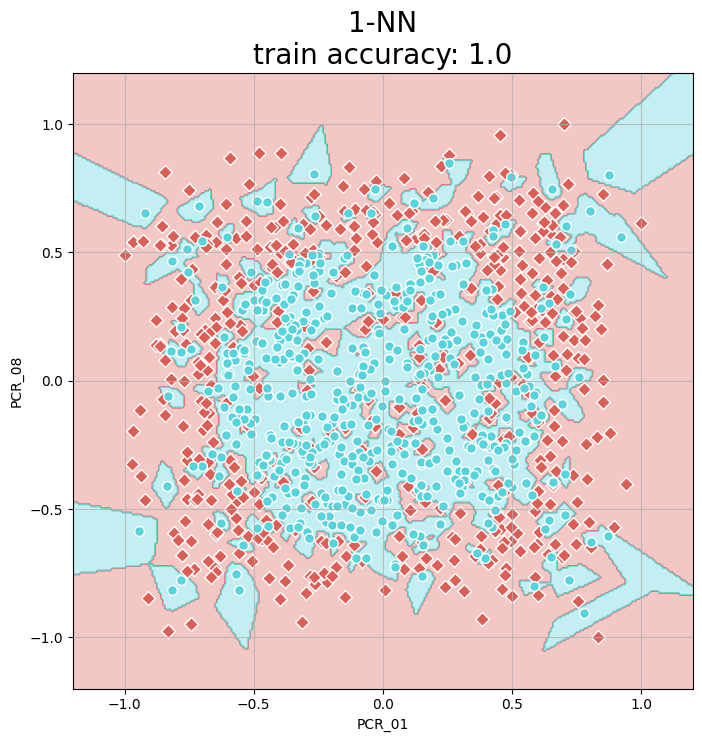

In [14]:
visualize_clf(q1_classifier, temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'],
              f'1-NN\ntrain accuracy: {q1_train_accuracy}', 'PCR_01', 'PCR_08')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


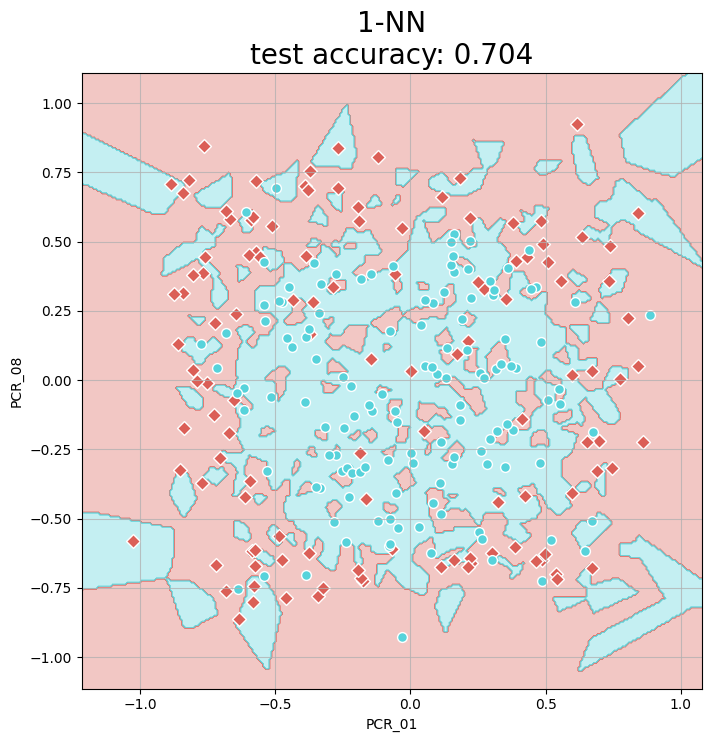

In [15]:
visualize_clf(q1_classifier, temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'],
              f'1-NN\ntest accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

In [16]:
def q2_range():
  for i in range(1, 20, 2):
    yield i
  for i in range(20, 695, 65):
    yield i

In [27]:
from sklearn.model_selection import cross_validate

h_parameters = pd.DataFrame({"k": [], "test_score": [], "train_score": []})
folds = 8
for k in q2_range():
  res = cross_validate(KNeighborsClassifier(n_neighbors=k), temp_train_df[['PCR_01', 'PCR_08']], y=temp_train_df['spread'], cv=folds, return_train_score=True)
  new_row = pd.DataFrame([[k, sum(res['test_score'])/folds, sum(res['train_score'])/folds]], columns=h_parameters.columns)
  h_parameters = pd.concat([new_row, h_parameters], ignore_index=True)

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

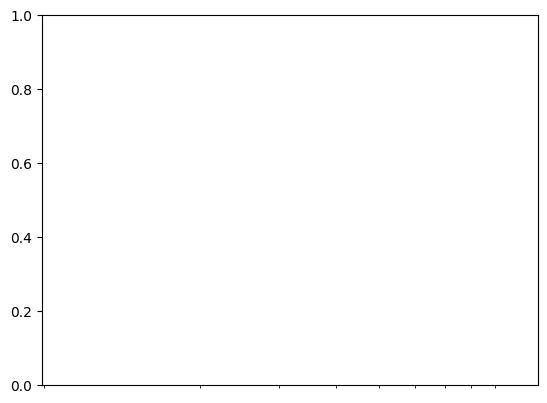

In [96]:
plt.semilogx('k', 'train_score', "g.-", data = h_parameters)
plt.semilogx('k', 'test_score', "m.-", data = h_parameters)
plt.xlabel ('K')
plt.ylabel ('(mean) train/test accuracy')
plt.title("K-NN validation and train accuracy")
plt.legend(prop = {'size':7},bbox_to_anchor=(1,1))
plt.grid()

In [62]:
best_k_scores = h_parameters[h_parameters['test_score']==h_parameters['test_score'].max()]
best_k = int(best_k_scores['k'].iloc[0])
best_k_scores

,k,test_score,train_score
10,20.0,0.779,0.787571


# Q2
The best `k` value is $20$, it scores $0.779$ validation accuracy and $0.787571$ train accuracy (average score estimated by cross validation).\
according to the curveplot, `k` values under $10$ lead to overfitting because trainiing accuracy is alot higher than validation accuracy. values over $20$ lead to underfitting, as we can see the accuracy for both train and validation drop significantly.


# Q3

In [63]:
q1_classifier = KNeighborsClassifier(n_neighbors=best_k)

q1_classifier.fit(X=temp_train_df[['PCR_01','PCR_08']], y=temp_train_df['spread'])
q1_train_accuracy = q1_classifier.score(temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'])
q1_test_accuracy = q1_classifier.score(temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'])

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


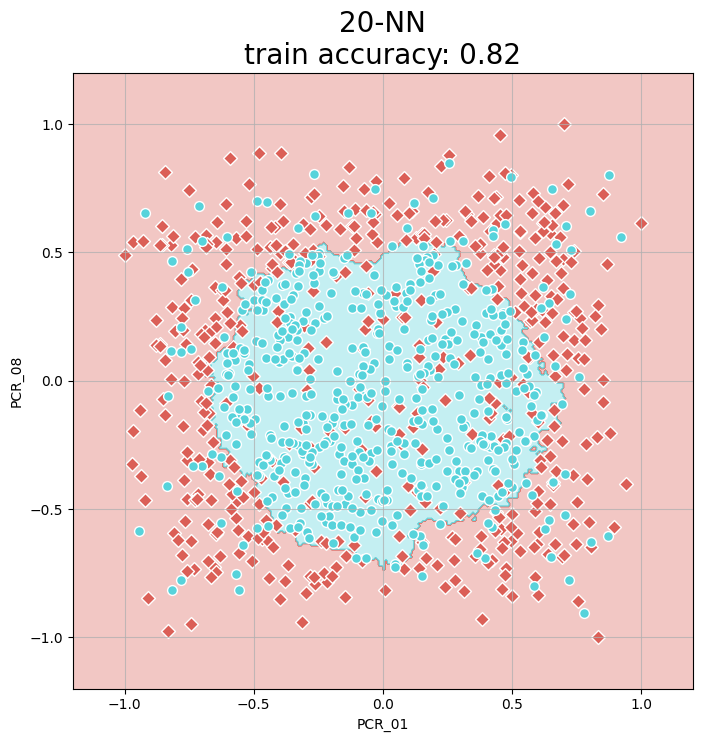

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


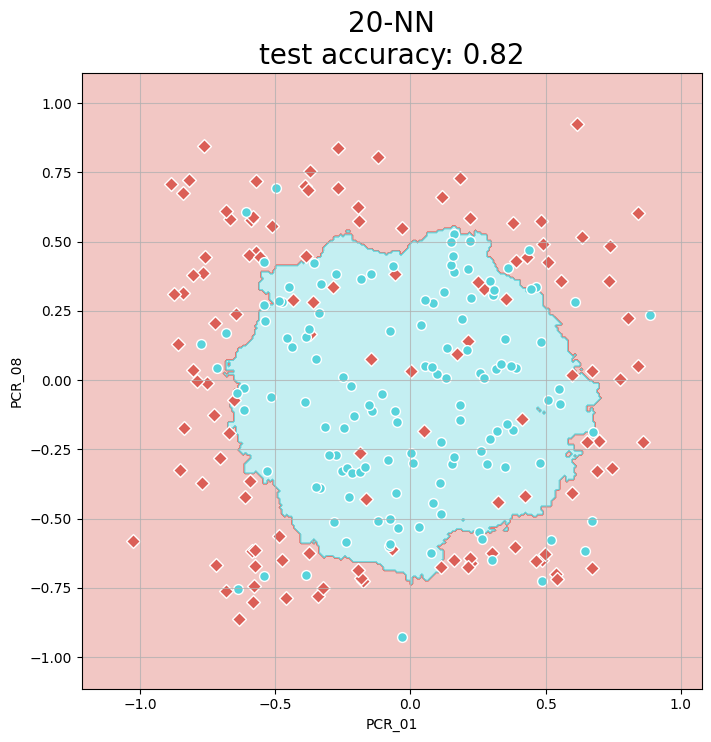

In [65]:
visualize_clf(q1_classifier, temp_train_df[['PCR_01', 'PCR_08']], temp_train_df['spread'],
              f'{best_k}-NN\ntrain accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

visualize_clf(q1_classifier, temp_test_df[['PCR_01', 'PCR_08']], temp_test_df['spread'],
              f'{best_k}-NN\ntest accuracy: {q1_test_accuracy}', 'PCR_01', 'PCR_08')

# Q4

First of all, notice how the 20-NN test accuracy is $0.82$ and 1-NN is $0.704$. Already we can tell that we have improved the model significantly.\
By observing the boundaries of the two models we can see how the 1-NN model has encountered overfitting. the boundary has alot of small "islands", contrary to the 20-NN model which shows 1 large area that classifies the data more reliably.

# Part 2

train accuracy:  0.719
test accuracy:  0.584


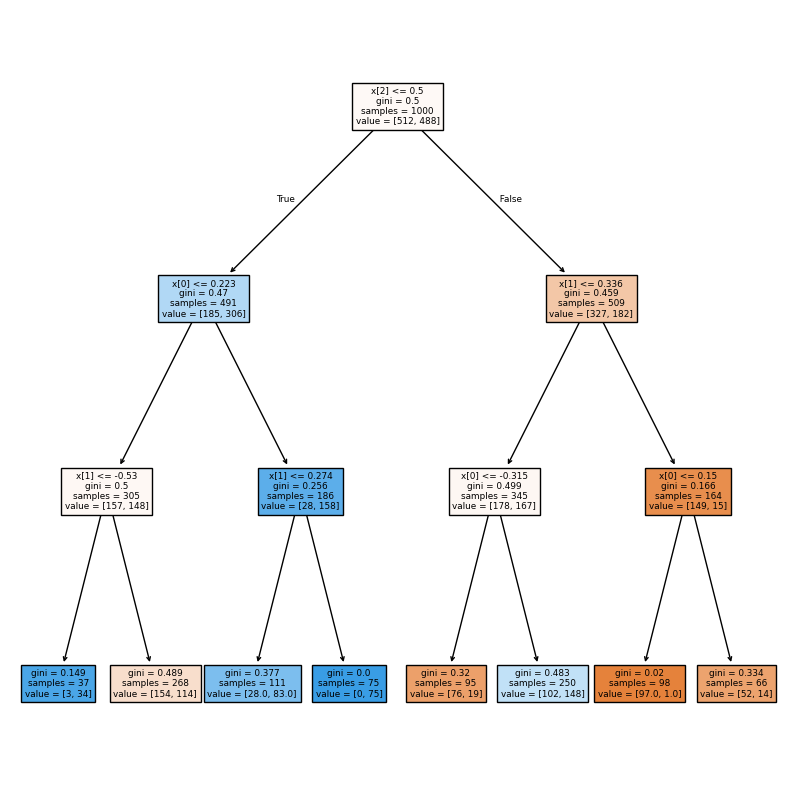

In [207]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

part2_train_df = train_df[['PCR_04', 'PCR_06', 'blood_type_group', 'risk']]
part2_test_df = test_df[['PCR_04', 'PCR_06', 'blood_type_group', 'risk']]

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], part2_train_df['risk'])

print('train accuracy: ', clf.score(X=part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_train_df['risk']))
print('test accuracy: ', clf.score(X=part2_test_df[['PCR_04', 'PCR_06', 'blood_type_group']], y=part2_test_df['risk']))

_ = plt.figure(figsize=(10,10))
_ = plot_tree(clf, filled=True)

Text(50.722222222222214, 0.5, 'depth')

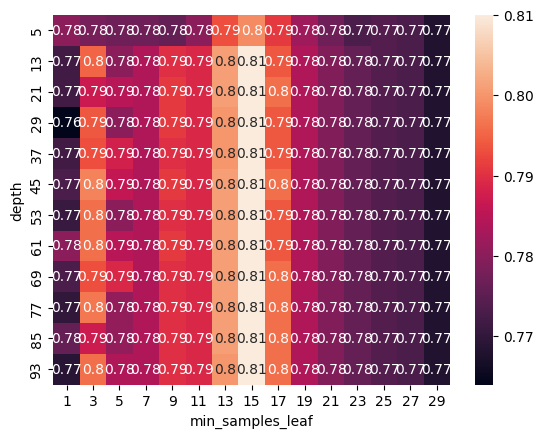

In [223]:
from sklearn.model_selection import cross_validate, GridSearchCV

folds = 5

depths = list(range(5,100,8))
min_samples_leaf = list(range(1,30,2))

parameters = {'max_depth': depths, 'min_samples_leaf': min_samples_leaf}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, cv=folds)
clf.fit(part2_train_df[['PCR_04', 'PCR_06', 'blood_type_group']], part2_train_df['risk'])

scores = clf.cv_results_['mean_test_score'].reshape(len(depths),len(min_samples_leaf))
scores = pd.DataFrame(scores, columns=min_samples_leaf, index=depths)
s = sns.heatmap(scores, annot=True, yticklabels=depths, xticklabels=min_samples_leaf)
s.set_xlabel('min_samples_leaf', fontsize=10)
s.set_ylabel('depth', fontsize=10)

In [220]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_min_samples_leaf', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])